## Dogs vs Cats on smaller dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import random
from shutil import copyfile

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /content/cats_and_dogs_filtered.zip

--2021-10-08 05:06:27--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.5.128, 64.233.184.128, 74.125.71.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.5.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M  38.0MB/s    in 1.7s    

2021-10-08 05:06:29 (38.0 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
# content -> cats_and_dogs_filtered -> train -> cats, dogs
# content -> cats_and_dogs_filtered -> validation -> cats, dogs

import os
import zipfile

local_zip = '/content/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
base_dir = '/content/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.301.jpg', 'cat.912.jpg', 'cat.564.jpg', 'cat.74.jpg', 'cat.63.jpg', 'cat.622.jpg', 'cat.552.jpg', 'cat.182.jpg', 'cat.431.jpg', 'cat.664.jpg']
['dog.62.jpg', 'dog.381.jpg', 'dog.621.jpg', 'dog.623.jpg', 'dog.888.jpg', 'dog.720.jpg', 'dog.647.jpg', 'dog.227.jpg', 'dog.112.jpg', 'dog.36.jpg']


In [ ]:
print('total training cat images :', len(os.listdir(train_cats_dir)))
print('total training dog images :', len(os.listdir(train_dogs_dir)))

print('total validation cat images :', len(os.listdir(valid_cats_dir)))
print('total validation dog images :', len(os.listdir(valid_dogs_dir)))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


In [ ]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

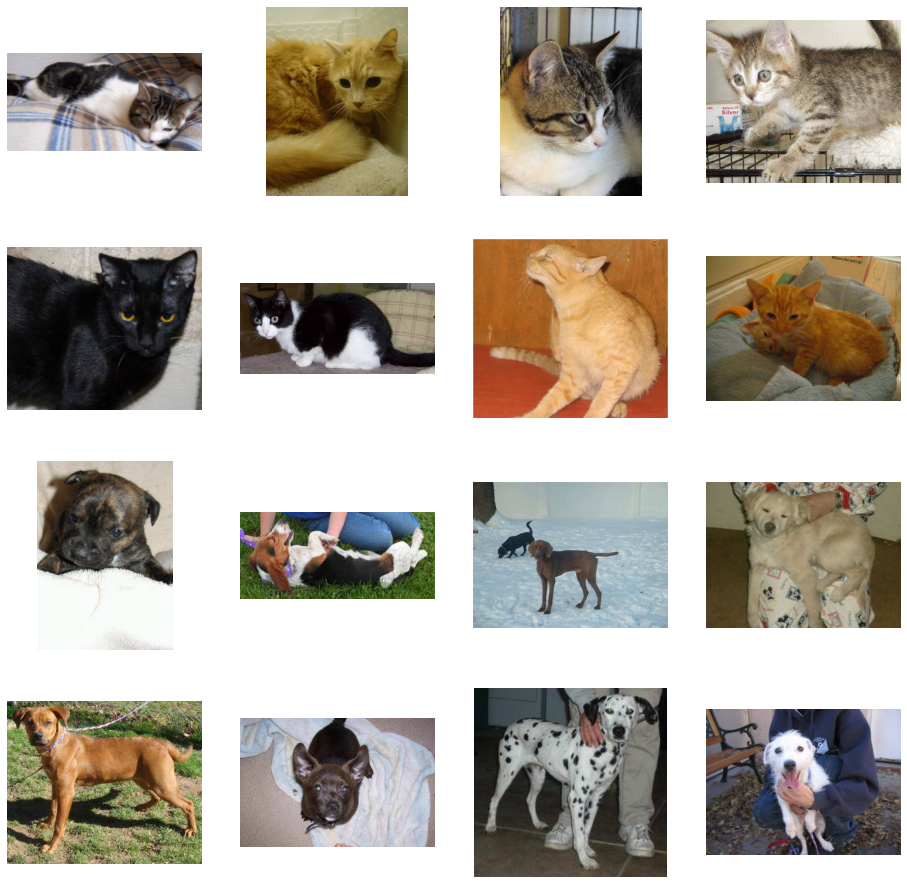

In [ ]:
# display a batch of 8 horse and 8 human pictures

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
# input image shape to be what we specify

IMG_HEIGHT = 300        
IMG_WIDTH = 300
CHANNELS = 3
NUM_CLASSES = 1

In [ ]:
model = Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 78400)             0

In [ ]:
# RMS is preferrable to SGD because RMSprop automates learning-rate tuning for us
# Adam, AdaGrad will also do good

optimizer   = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
                          train_dir,   
                          target_size=(IMG_HEIGHT, IMG_WIDTH),       # same as input image size
                          batch_size=20,             
                          seed=20,                      
                          class_mode='binary')             

Found 2000 images belonging to 2 classes.


In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./255.)

valid_generator = valid_datagen.flow_from_directory(
                          valid_dir, 
                          target_size=(IMG_HEIGHT, IMG_WIDTH),  
                          batch_size=20,
                          seed=20,
                          class_mode='binary')

Found 1000 images belonging to 2 classes.


In [ ]:
early_stopping    = EarlyStopping(monitor='val_loss', patience=7)
reduce_lr         = ReduceLROnPlateau(monitor='val_loss', patience=7, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
EPOCHS = 20
CALLBACKS = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(train_generator,
                  # steps_per_epoch = 100,                          # steps_per_epoch = total training records / batch size = 2000/20
                    validation_data = valid_generator,
                  # validation_steps = 50,                          # validation_steps = total validation records / batch size = 1000/20
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/20
100/100 [==============================] - 21s 161ms/step - loss: 1.0174 - accuracy: 0.5340 - val_loss: 0.6733 - val_accuracy: 0.5020
Epoch 2/20
100/100 [==============================] - 16s 160ms/step - loss: 0.7093 - accuracy: 0.6075 - val_loss: 0.6780 - val_accuracy: 0.6080
Epoch 3/20
100/100 [==============================] - 16s 159ms/step - loss: 0.5959 - accuracy: 0.7090 - val_loss: 0.6049 - val_accuracy: 0.7090
Epoch 4/20
100/100 [==============================] - 16s 160ms/step - loss: 0.4761 - accuracy: 0.7845 - val_loss: 0.5918 - val_accuracy: 0.7260
Epoch 5/20
100/100 [==============================] - 16s 161ms/step - loss: 0.3322 - accuracy: 0.8605 - val_loss: 0.7257 - val_accuracy: 0.7110
Epoch 6/20
100/100 [==============================] - 16s 161ms/step - loss: 0.2252 - accuracy: 0.9145 - val_loss: 0.8367 - val_accuracy: 0.6870
Epoch 7/20
100/100 [==============================] - 16s 160ms/step - loss: 0.1186 - accuracy: 0.9630 - val_loss: 1.2371 - val_ac

In [ ]:
model.evaluate(valid_generator)

50/50 [==============================] - 5s 96ms/step - loss: 1.7180 - accuracy: 0.6720


[1.7180253267288208, 0.671999990940094]

<Figure size 432x288 with 0 Axes>

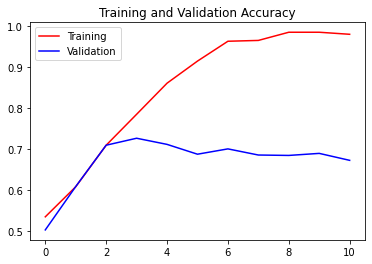

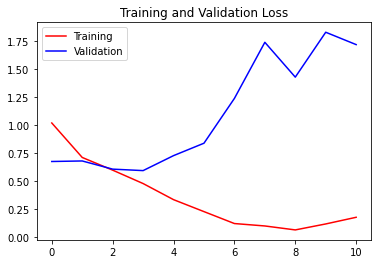

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

In [ ]:
# load image to test

import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a dog")
    
  else:
    print(fn + " is a cat")

Saving cat.jfif to cat.jfif
[0.]
cat.jfif is a cat


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


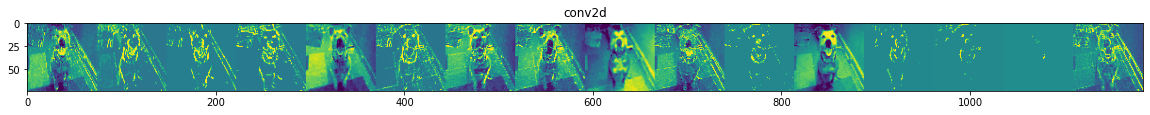

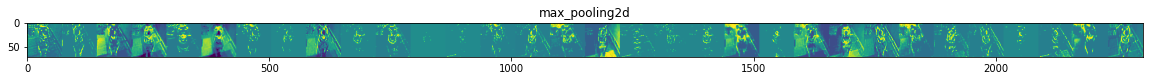

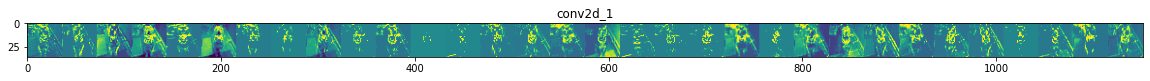

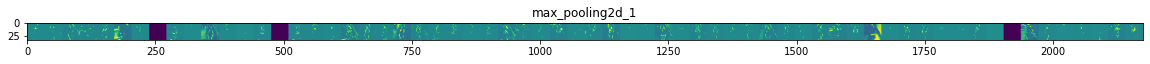

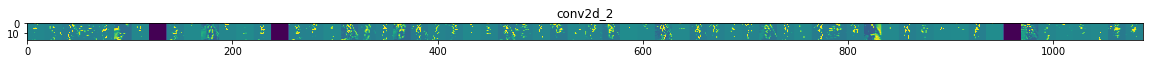

In [ ]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

In [ ]:
# to terminate the kernel and free memory resources

import os, signal
os.kill(os.getpid(), signal.SIGKILL)

## Dogs vs Cats on bigger dataset

**Exercise 5**

In this exercise you will train a CNN on the FULL Cats-v-dogs dataset. This will require you doing a lot of data preprocessing because the dataset isn't split into training and validation for you.

In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/content/cats-and-dogs.zip"

--2021-10-08 06:19:53--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 80.67.92.138, 2a02:26f0:11e:4b5::e59, 2a02:26f0:11e:4bc::e59
Connecting to download.microsoft.com (download.microsoft.com)|80.67.92.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/content/cats-and-dogs.zip’

/content/cats-and-d 100%[===================>] 786.68M   158MB/s    in 5.0s    

2021-10-08 06:19:58 (157 MB/s) - ‘/content/cats-and-dogs.zip’ saved [824894548/824894548]



In [ ]:
import os
import zipfile

local_zip = '/content/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# content -> PetImages -> cats, dogs
# training and validation directory not given separately

print(len(os.listdir('/content/PetImages/Cat/')))
print(len(os.listdir('/content/PetImages/Dog/')))

12501
12501


In [ ]:
try:
    os.mkdir('/content/cats-v-dogs')
    os.mkdir('/content/cats-v-dogs/training')
    os.mkdir('/content/cats-v-dogs/testing')
    os.mkdir('/content/cats-v-dogs/training/cats')
    os.mkdir('/content/cats-v-dogs/training/dogs')
    os.mkdir('/content/cats-v-dogs/testing/cats')
    os.mkdir('/content/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [ ]:
# it will split the directory and separate train and validation images
# 90% images will be copied to training folder
# 10% to validation

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)

In [ ]:
CAT_SOURCE_DIR = "/content/PetImages/Cat/"
TRAINING_CATS_DIR = "/content/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/content/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/content/PetImages/Dog/"
TRAINING_DOGS_DIR = "/content/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/content/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [ ]:
print(len(os.listdir('/content/cats-v-dogs/training/cats/')))
print(len(os.listdir('/content/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/content/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/content/cats-v-dogs/testing/dogs/')))

12378
12371
2378
2371


In [ ]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
CHANNELS = 3
NUM_CLASSES = 1

In [ ]:
model = Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [ ]:
# RMS is preferrable to SGD because RMSprop automates learning-rate tuning for us
# Adam, AdaGrad will also do good

optimizer   = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss        = tf.keras.losses.BinaryCrossentropy()
metrics     = ['accuracy']

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = '/content/cats-v-dogs/training/'

train_datagen = ImageDataGenerator(rescale = 1./255.)         

train_generator = train_datagen.flow_from_directory(
                          TRAINING_DIR,   
                          target_size = (IMG_HEIGHT, IMG_WIDTH),  
                          batch_size = 100,             
                          seed = 20,                      
                          class_mode = 'binary')             

Found 24747 images belonging to 2 classes.


In [ ]:
VALIDATION_DIR = '/content/cats-v-dogs/testing/'

valid_datagen = ImageDataGenerator(rescale = 1./255.)

valid_generator = valid_datagen.flow_from_directory(
                          VALIDATION_DIR, 
                          target_size = (IMG_HEIGHT, IMG_WIDTH),  
                          batch_size = 100,
                          seed = 20,
                          class_mode = 'binary')

Found 4749 images belonging to 2 classes.


In [ ]:
early_stopping    = EarlyStopping(monitor='val_loss', patience=7)
reduce_lr         = ReduceLROnPlateau(monitor='val_loss', patience=7, min_lr=0.001, mode='min', verbose=1)
model_checkpoint  = ModelCheckpoint(monitor='val_loss', filepath='./best_model.h5', save_best_only=True)

In [ ]:
EPOCHS = 15
CALLBACKS = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
history = model.fit(train_generator,
                    validation_data = valid_generator,
                    verbose = 1,
                    epochs = EPOCHS,
                    callbacks = CALLBACKS)

Epoch 1/15
114/248 [============>.................] - ETA: 46s - loss: 0.8609 - accuracy: 0.5809

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

248/248 [==============================] - 104s 411ms/step - loss: 0.7173 - accuracy: 0.6395 - val_loss: 0.5327 - val_accuracy: 0.7370
Epoch 2/15
248/248 [==============================] - 101s 405ms/step - loss: 0.5033 - accuracy: 0.7552 - val_loss: 0.4014 - val_accuracy: 0.8111
Epoch 3/15
248/248 [==============================] - 101s 409ms/step - loss: 0.4273 - accuracy: 0.8034 - val_loss: 0.3685 - val_accuracy: 0.8324
Epoch 4/15
248/248 [==============================] - 101s 408ms/step - loss: 0.3682 - accuracy: 0.8378 - val_loss: 0.3903 - val_accuracy: 0.8124
Epoch 5/15
248/248 [==============================] - 101s 407ms/step - loss: 0.3045 - accuracy: 0.8692 - val_loss: 0.2777 - val_accuracy: 0.8764
Epoch 6/15
248/248 [==============================] - 102s 409ms/step - loss: 0.2431 - accuracy: 0.8997 - val_loss: 0.1752 - val_accuracy: 0.9360
Epoch 7/15
248/248 [==============================] - 101s 407ms/step - loss: 0.1741 - accuracy: 0.9301 - val_loss: 0.1074 - val_accura

<Figure size 432x288 with 0 Axes>

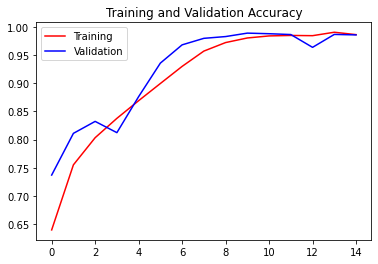

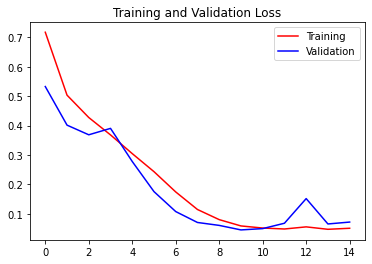

<Figure size 432x288 with 0 Axes>

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']

epochs   = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training')
plt.plot(epochs, val_acc, 'b', label = 'Validation')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(loss))

plt.plot(epochs, loss, 'r', label = 'Training')
plt.plot(epochs, val_loss, 'b', label = 'Validation')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

In [ ]:
from google.colab import files
from keras.preprocessing import image
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving cat.jpg to cat.jpg
[0.]
cat.jpg is a cat
